Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.stats.api as sms
from tqdm.auto import tqdm
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, mannwhitneyu, kstest

Посмотрим общую информацию о датасете

In [2]:
df = pd.read_csv('problem2.csv', sep=';')

In [3]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


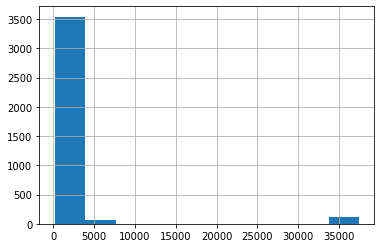

In [4]:
df.query('revenue > 0').revenue.hist()

In [5]:
df.query('testgroup == "a"').user_id.agg({'count', 'nunique'})

nunique    202103
count      202103
Name: user_id, dtype: int64

In [6]:
df.query('testgroup == "b"').user_id.agg({'count', 'nunique'})

nunique    202667
count      202667
Name: user_id, dtype: int64

Посмотрим общую статистическую инфрормацию о доходе в разрезе групп 'а' и 'в'

In [7]:
df.query('revenue > 0 & testgroup == "a"').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [8]:
df.query('revenue > 0 & testgroup == "b"').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

Как видно значения процентилей revenue в двух группах на взгляд сильно отличаются друг от друга, что зразу же наталкивает на мысль об услових, в которых проводился A/B тест (в т.ч. репрезентативность дисперсии), что косвенно подтверждается показателем стандартного отклонения 'a' группы.
Построим boxplot для того, чтобы более подробно посмотреть на распределение revenue по группам.

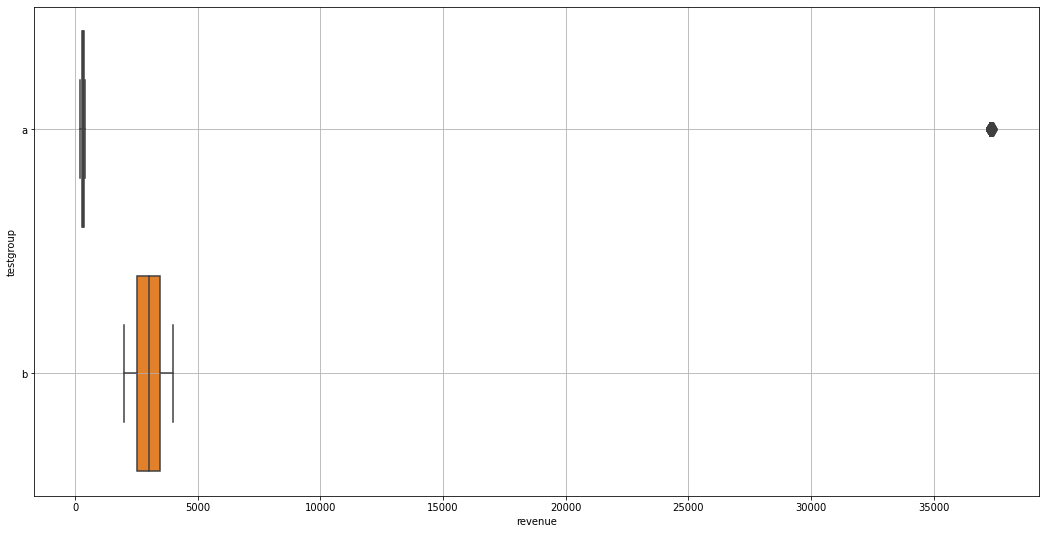

In [9]:
plt.figure(figsize=(18,9))
sns.boxplot(data = df.query('revenue > 0'), x = 'revenue', y = 'testgroup', orient='h', fliersize = 10.0)
plt.grid()

In [10]:
df.query('revenue > 0 & testgroup == "a"').revenue.quantile(0.93)

399.0

In [11]:
df.query('revenue > 0 & testgroup == "a"').revenue.quantile(0.95)

37299.65

У нас сильный выброс в группе 'a', в которой 93% дохода составляют значения меньше 399 рублей, а 5% больше 37К.

Почему так получилось? Пока что версии две:
1. На часть пользователей так хорошо подействовал набор акционных товаров в группе 'a', что они накупили товаров на сумму > 37К.
2. Что-то не так с системой сплитования трафика и группы пользователей сформированны некорректно.

Начнем с конца и с помощью A/A теста проверим корректность работы системы сплитования.

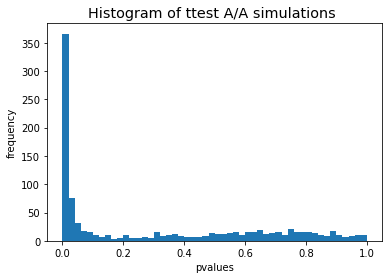

0.462

In [12]:
n = 404770 # размер оригинальной выборки
simulations = 1000
n_s = 1000 # количество наблюдений в формирующейся подвыборке
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query('testgroup == "a"').revenue.sample(n_s, replace = False).values
    s2 = df.query('testgroup == "b"').revenue.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Как видно значение FPR(False Positive Rate)> 0.05, что означает:
- Наша система сплитования пользователей по группам работает неправильно, а соответственно и результаты A/B теста считать достоверными не стоит.

В данном случае я бы порекомендовал сначала поправить работу системы, после чего провести еще один тест.

Но допустим, что все таки система сплитования работает правильно, и мы имеем дело с очень активными покупателями, которым очень понравился акционный набор.

В таком случае мы можем следующим образом оценить наши данные:

- Сначала посчитаем метрики по группам:
    - Общий доход
    - ARPU
    - ARPPU
    - СR

- Сравним являются ли изменения метрик статистически значимыми:

    - Сравним как отличается общая сумма дохода, который нам принесли пользователи тестовой и контрольной групп.
    - Сравним ARPU по группам.
    - Сравним ARPPU.
    - Сравним отношение (Conversion Rate) количества пользователей, которые оформили заказ к общему количеству пользоателей по группам.

Для всех сревнений в качестве оценшика я выбрал бутстрап, поскольку метрики другими методами я не протестрию, а для первой задачи, при такой форме распределения, рисковать использовать t-test не хочется, а тест Манна_Уитни в данном случае будет тяжело проинтепретировать.

И да, для Bootstrap желательно, чтобы наша выборка действительно была репрезентативной, но мы же уже решили, что да будет так)

In [13]:
revenue_control = df.query('testgroup == "a"').revenue.sum()

In [14]:
revenue_test = df.query('testgroup == "b"').revenue.sum()

In [15]:
revenue_diff = round((revenue_test - revenue_control) / revenue_control * 100 , 2)

In [16]:
arpu_control = df.query('testgroup == "a"').revenue.sum() / df.query('testgroup == "a"').user_id.count()

In [17]:
arpu_test = df.query('testgroup == "b"').revenue.sum() / df.query('testgroup == "b"').user_id.count()

In [18]:
arpu_diff = round((arpu_test - arpu_control) / arpu_test * 100, 2)

In [21]:
arppu_control = df.query('testgroup == "a" & revenue > 0').revenue.sum() / \
                df.query('testgroup == "a" & revenue > 0').user_id.count()

In [22]:
arppu_test = df.query('testgroup == "b" & revenue > 0').revenue.sum() /  \
            df.query('testgroup == "b" & revenue > 0').user_id.count()

In [23]:
arppu_diff = round((arppu_test - arppu_control) / arppu_control * 100, 2)

In [24]:
cr_control = df.query('testgroup == "a" & revenue > 0').user_id.count() / df.query('testgroup == "a"').user_id.count() * 100

In [25]:
cr_test = df.query('testgroup == "b" & revenue > 0').user_id.count() / df.query('testgroup == "b"').user_id.count() * 100

In [26]:
cr_diff = round((cr_test - cr_control) / cr_control * 100, 2)

In [27]:
pd.DataFrame({'absolut_revenue' : [revenue_control, revenue_test, revenue_diff],
              'arpu' : [arpu_control, arpu_test, arpu_diff],
              'arppu' : [arppu_control, arppu_test, arppu_diff],
              'cr' : [cr_control, cr_test, cr_diff]}, index = ['control_group', 'test_group', 'difference'])

,absolut_revenue,arpu,arppu,cr
control_group,5136189.00,25.413720,2663.998444,0.953969
test_group,5421603.00,26.751287,3003.658172,0.890624
difference,5.56,5.000000,12.750000,-6.640000


Как видно из данных абсолютный доход, доход на пользователя и доход на платящего пользователя выросли по сравнению с контрольной группой, на 5.56%, 5%, и 12.7% соответственно, а конверсия упала на 6.64%.

Теперь проверим являются ли эти изменения статистически значимыми или это всего лишь следствие случайности.

# Сравниваем доход

    Н0 - размер общего дохода в контрольной и тестовой группах статистически не различается, а любые различия следствия случайности.
    Н1 - различия размера общего дохода в группах не случайны и статистически значимы.

In [28]:
def get_bootstrap_revenue(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
  
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data_1 = []
    boot_data_2 = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        sample_data_1 = data_column_1.sample(boot_len, replace=True)
        boot_data_1.append(sample_data_1.sum())
        
        sample_data_2 = data_column_2.sample(boot_len, replace=True)
        
        boot_data_2.append(sample_data_2.sum())
        
    
     
    sum_a = np.array(boot_data_1)
    sum_b= np.array(boot_data_2)
    
    
    test_group_a = []
    for i in range(len(sum_a)): test_group_a.append('a')
    test_group_a = np.array(test_group_a)
    a_group = pd.DataFrame({'revenue': sum_a, 'test_group' : test_group_a})
    
    test_group_b = []
    for i in range(len(sum_b)): test_group_b.append('b')
    test_group_b = np.array(test_group_b)
    b_group = pd.DataFrame({'revenue': sum_b, 'test_group' : test_group_b})
    
    summ = pd.concat([a_group, b_group], axis=0)
    
    # Выводим доверительные интервалы для получившихся распределений
    print('Group A: ', stats.t.interval(0.99, len(sum_a)-1, loc=np.mean(sum_a), scale=stats.sem(sum_a)))
    print('Group B: ', stats.t.interval(0.99, len(sum_b)-1, loc=np.mean(sum_b), scale=stats.sem(sum_b)))
    
    #plt.figure(figsize=(18,5))
    sns.pointplot(y = 'revenue', x = 'test_group', hue='test_group', data=summ, dodge=True, join=False, orient='v')
    plt.grid()
    

In [29]:
revenue_a = df.query('testgroup == "a"').revenue
revenue_b = df.query('testgroup == "b"').revenue


Group A:  (5125549.418823948, 5172421.513176052)
Group B:  (5416678.960324675, 5431557.837675326)


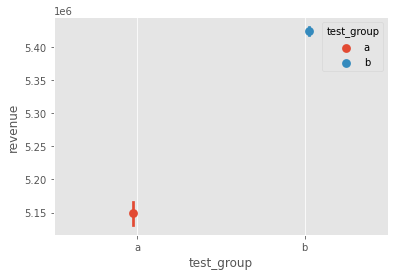

In [30]:
get_bootstrap_revenue(revenue_a, revenue_b, boot_it = 2000)

Как мы видим доверительные интервалы обоих групп не пересекаются между собой, что дает нам право отклонить нулевую гипотезу. Такого же результата мы достигаем при удвоении размера выборки и количества итераций.

# Сравниваем ARPU
    Н0 - показатель ARPU в контрольной и тестовой группах статистически не различается, а любые различия следствия случайности.
    Н1 - различия показателя ARPU в группах не случайны и статистически значимы.

In [31]:
def get_bootstrap_ARPU(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
  
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data_1 = []
    boot_data_2 = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        sample_revenue_1 = data_column_1.sample(boot_len, replace=True)
        sample_arpu_1 = sample_revenue_1.sum() / sample_revenue_1.shape[0]
        boot_data_1.append(sample_arpu_1)
        
        sample_revenue_2 = data_column_2.sample(boot_len, replace=True)
        sample_arpu_2 = sample_revenue_2.sum() / sample_revenue_2.shape[0]
        boot_data_2.append(sample_arpu_2)
        
        
    
    boot_data_1 = np.array(boot_data_1)
    boot_data_2 = np.array(boot_data_2)
    
    test_group_a = []
    for i in range(len(boot_data_1)): test_group_a.append('a')
    test_group_a = np.array(test_group_a)
    a_group = pd.DataFrame({'arpu': boot_data_1, 'test_group' : test_group_a})
    
    test_group_b = []
    for i in range(len(boot_data_2)): test_group_b.append('b')
    test_group_b = np.array(test_group_b)
    b_group = pd.DataFrame({'arpu': boot_data_2, 'test_group' : test_group_b})
    
    arpu = pd.concat([a_group, b_group], axis=0)
    
    # Выводим доверительные интервалы для получившихся распределений
    print('Group A: ', stats.t.interval(0.99, len(boot_data_1)-1, loc=np.mean(boot_data_1), scale=stats.sem(boot_data_1)))
    print('Group B: ', stats.t.interval(0.99, len(boot_data_2)-1, loc=np.mean(boot_data_2), scale=stats.sem(boot_data_2)))

    
    #plt.figure(figsize=(18,5))
    sns.pointplot(y = 'arpu', x = 'test_group', hue='test_group', data=arpu, dodge=True, join=False, orient='v', estimator=np.median)
    plt.grid()
    

In [32]:
arpu_group_a = df.query('testgroup == "a"').revenue
arpu_group_b = df.query('testgroup == "b"').revenue


Group A:  (25.3255857090968, 25.56438940772044)
Group B:  (26.703349393309797, 26.778656503062077)


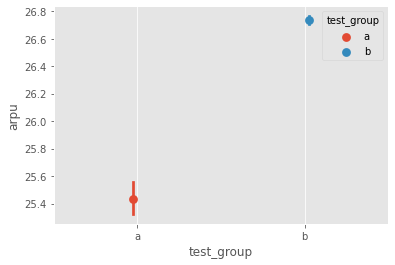

In [33]:
get_bootstrap_ARPU(arpu_group_a, arpu_group_b, boot_it = 2000)

Здесь также получены статистически значимые различия, доверительные интервалы также не пересекаются, мы можем отклонить нулевую гипотезу. Такого же результата мы достигаем при удвоении размера выборки и количества итераций.

# Считаем ARPPU
    Н0 - показатель ARPPU в контрольной и тестовой группах статистически не различается, а любые различия следствия случайности.
    Н1 - различия показателя ARPPU в группах не случайны и статистически значимы.

In [34]:
def get_bootstrap_ARPPU(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
  
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data_1 = []
    boot_data_2 = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        sample_revenue_1 = data_column_1.sample(boot_len, replace=True)
        sample_arpu_1 = sample_revenue_1.sum() / sample_revenue_1.shape[0]
        boot_data_1.append(sample_arpu_1)
        
        sample_revenue_2 = data_column_2.sample(boot_len, replace=True)
        sample_arpu_2 = sample_revenue_2.sum() / sample_revenue_2.shape[0]
        boot_data_2.append(sample_arpu_2)
    
     
    arppu_a = np.array(boot_data_1)
    arppu_b = np.array(boot_data_2)
    
    
    test_group_a = []
    for i in range(len(arppu_a)): test_group_a.append('a')
    test_group_a = np.array(test_group_a)
    a_group = pd.DataFrame({'arppu': arppu_a, 'test_group' : test_group_a})
    
    test_group_b = []
    for i in range(len(arppu_b)): test_group_b.append('b')
    test_group_b = np.array(test_group_b)
    b_group = pd.DataFrame({'arppu': arppu_b, 'test_group' : test_group_b})
    
    arppu = pd.concat([a_group, b_group], axis=0)
    
    # Выводим доверительные интервалы для получившихся распределений
    print('Group A: ', stats.t.interval(0.95, len(arppu_a)-1, loc=np.mean(arppu_a), scale=stats.sem(arppu_a)))
    print('Group B: ', stats.t.interval(0.95, len(arppu_b)-1, loc=np.mean(arppu_b), scale=stats.sem(arppu_b)))
    
    #plt.figure(figsize=(18,5))
    sns.pointplot(y = 'arppu', x ='test_group', hue='test_group', data=arppu, dodge=True, join=False, orient='v', estimator=np.median)
    plt.grid()
    
    
    
    

In [35]:
arppu_group_a = df.query('revenue > 0 & testgroup == "a"').revenue
arppu_group_b = df.query('revenue > 0 & testgroup == "b"').revenue


Group A:  (2648.073707764398, 2666.354146488714)
Group B:  (3003.066347064689, 3004.2056327070945)


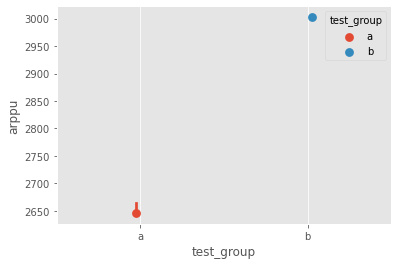

In [36]:
get_bootstrap_ARPPU(arppu_group_a,arppu_group_b, boot_it = 2000)

Как и в других случаях были достигнуты статистически значимые различия, доверительные интервалы также не пересекаются, отклоняем нулевую гипотезу. Такого же результата мы достигаем при удвоении размера выборки, количества итераций и при выборе в качестве оценщика - медианы.

# Считаем Convertion Rate
    Н0 - соотношение количества пользователей оформивших заказ к общему количеству пользователей в контрольной и тестовой группах статистически не различается, а любые различия следствия случайности.
    Н1 - различия СR в группах не случайны и статистически значимы.

In [37]:
def get_bootstrap_CR(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
  
    ):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data_1 = []
    boot_data_2 = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        sample_data_1 = data_column_1.sample(boot_len, replace=True)
        sample_1 = sample_data_1.query('revenue > 0').shape[0] / sample_data_1.shape[0]
        boot_data_1.append(round(sample_1 * 100, 3))
        
        sample_data_2 = data_column_2.sample(boot_len, replace=True)
        sample_2 = sample_data_2.query('revenue > 0').shape[0] / sample_data_2.shape[0]
        boot_data_2.append(round(sample_2 * 100, 3))
        
    
     
    cr_a = np.array(boot_data_1)
    cr_b = np.array(boot_data_2)
    
    
    test_group_a = []
    for i in range(len(cr_a)): test_group_a.append('a')
    test_group_a = np.array(test_group_a)
    a_group = pd.DataFrame({'CR': cr_a, 'test_group' : test_group_a})
    
    test_group_b = []
    for i in range(len(cr_b)): test_group_b.append('b')
    test_group_b = np.array(test_group_b)
    b_group = pd.DataFrame({'CR': cr_b, 'test_group' : test_group_b})
    
    cr = pd.concat([a_group, b_group], axis=0)
    
    
    # Выводим доверительные интервалы для получившихся распределений   
    print('Group A: ', stats.t.interval(0.95, len(cr_a)-1, loc=np.mean(cr_a), scale=stats.sem(cr_a)))
    print('Group B: ', stats.t.interval(0.95, len(cr_b)-1, loc=np.mean(cr_b), scale=stats.sem(cr_b)))
    
    #plt.figure(figsize=(18,5))
    sns.pointplot(y = 'CR', x ='test_group', hue='test_group', data=cr, dodge=True, join=False, orient='v')
    plt.grid()

    

In [38]:
cr_group_a = df.query('testgroup == "a"')
cr_group_b = df.query('testgroup == "b"')


Group A:  (0.9531781451715079, 0.9550578548284919)
Group B:  (0.889872656752301, 0.8917183432476989)


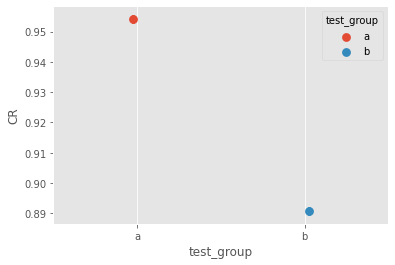

In [39]:
get_bootstrap_CR(cr_group_a, cr_group_b, boot_it = 2000)

CR также продемонстрировал статистически значимые различия, доверительные интервалы также не пересеклись и мы отклоняем нулевую гипотезу. Такого же результата мы достигаем при удвоении размера выборки, количества итераций и при выборе в качестве оценщика - медианы.

# Вывод:

    1. Я считаю, что в силу того, что наши пользователи были некорректным образом распределены по группам, не стоит говорить о том, что нами получены статистически достоверные результаты тестирования. Необходимо наладить работу сплит-системы и повторить эксперемент. P.S. исключение из основной выборки наблюдений с revenue > 25000 никак не повлиял на результаты A/A теста.

    2. Все же, если ограничиться этим набором данных, то при тестировании гипотез о неравенстве общего дохода, метрик ARPU, ARPPU нами во всех случаях получены статистически значимые различия, которые позволяют говорить о том, что набор акционных предложений, который был предоставлен тестовой группе позволил нам повысить ARPU на 5%, а ARPPU на 12.75% по сравнению с акционным набором предложенным контрольной группе пользователей, а значит именно этот набор можно считать лучшим.

    3. В качестве основных метрик, на основании которых стоит принимать решение в данном случае я бы выделил ARPPU, поскольку как мы увидели даже при условии того, что по итогам эксперимента показатель конверсии (CR) снизился, доход с одного платящего пользователя вырос приблизительно на 340($, руб.), что я считаю более важным изменением.